In [45]:
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd


import numpy as np
from matplotlib import pyplot as plt
import sklearn.linear_model as sklm
import scipy
import sklearn
%matplotlib inline

# Data process

## Getting times series

In [2]:
# основные константы
kb = 1.38064e-23 # постоянная Больцмана
T = 273.15 + 20 # температура в K
theta = np.pi/6 # угол рассеяния
n = 1.333 # показатель преломления
eta = 0.958e-3 # Н * с/м^2 - динамическая вязкость воды
l = 633e-9 # Длина волны лазера

coeff = 2*(kb * T/(3 * np.pi * eta)) * (4 * np.pi * n / l)**2 * np.sin(theta/2)**2
#coeff = 2*kb*T*( 4*np.pi*n/l*np.sin(theta/2) )**2/(6*np.pi*eta)
#типы частиц в растворе
d = 100e-9 #размер частицы в нм
w = np.arange(1,10**4) #спектр

def getOneParticleI(w, d1, a=1):
    G1 = coeff / d1 #Лоренц, соответствующий размеру d1
    y1 = a*G1 / ((2 * np.pi * w)**2 + G1**2)
    return y1

# функция генерирует Лоренца по частоте и размеру частицы
Lorenz = getOneParticleI(w, d,a=1) 

In [40]:
#исследуемый диапазон размеров частиц
# d_min = 1e-9 # 1 нм
# d_max = 1e-4 
# N = 256 # Число узлов в сетке по \Gamma

#сетка по \Gamma со сгущением к более крупным размерам
def getPowMesh(N, d_min, d_max):
    G = np.zeros(N)
    #диапазон Лоренцов, соответствующих минимальному и максимальному размерам
    G_min = coeff/d_max
    G_max = coeff/d_min
    #определяем сетку по ним
    p = (G_max/G_min)**(1/(N-1))
    for j in range(N):
        G[j] = G_min * (p**j)
    return G

#равномерная сетка по \Gamma
def getLinMesh(N, d_min, d_max):
    G_min = coeff/d_max
    G_max = coeff/d_min
    G = np.linspace(G_min, G_max, N)
    return G


# Матрица коэффициентов A переопределенной системы
def defineSystem(G, w):
    N = G.size
    M = w.size # Число точек по частоте
    A = np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            A[i,j] = G[j] / ((2 * np.pi * w[i])**2 + G[j]**2)
    return A

In [41]:
def LRsolve(A, y, G):
    # Ridge regression
    clf = sklm.Ridge(alpha = 5e-7)
    clf.fit(A, y)
    a1 = clf.coef_

    fig = plt.figure()
    ax = plt.subplot(3,1,1)
    line, = plt.plot(1e+9 * coeff/G, a1,'.-')
    ax.set_xscale('log')
    plt.xlim(1e9*d_min, 1e9*d_max)
    
    M = A.shape[0]
    N = A.shape[1]
    
    # Non-negative ridge regression
    alpha = 1.3e-7
    B = np.zeros((M+N, N))
    B[0:M,:] = A
    B[M::, :] = alpha * np.eye(N)
    y_ = np.zeros(M+N)
    y_[0:M] = y
    a2, rnorm = scipy.optimize.nnls(B,y_)

    ax = plt.subplot(3,1,2)
    line, = plt.plot(1e+9 * coeff/G, a2,'.-')
    ax.set_xscale('log')
    plt.xlim(1e9*d_min, 1e9*d_max)

    # Lasso regression
    clf = sklm.LassoCV()
    clf.fit(A, y)
    a3 = clf.coef_

    # fig = plt.figure()
    ax = plt.subplot(3,1,3)
    line, = plt.plot(1e+9 * coeff/G, a3,'.-')
    ax.set_xscale('log')
    plt.xlim(1e9*d_min, 1e9*d_max)
    
    #print max particle size in nm
    i, = np.where( a1==max(a1) )
    print('Particle size in a1, nm = ', 1e+9*coeff/G[i])
    i, = np.where( a2==max(a2) )
    print('Particle size in a2, nm = ', 1e+9*coeff/G[i])
    i, = np.where( a3==max(a3) )
    print('Particle size in a3, nm = ', 1e+9*coeff/G[i])
    

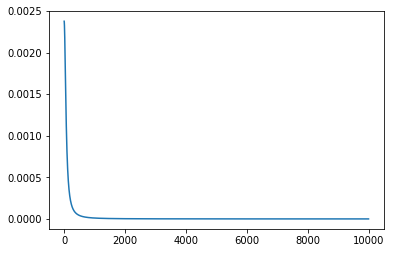

In [3]:
plt.plot(w,Lorenz)

# NN

5 - 350 nm was covered by 2200 diameters

In [4]:
from sklearn.preprocessing import normalize

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from keras import backend
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Getting dataset for NN

In [6]:
# эта функция усредняет лоренц так, что на выходе получаем 100 точек
def get_mean_lor(lor):
    out = np.zeros(100)
    for i in range(lor.shape[0]-100):
        out[i//100] = lor[i:i+100].mean()
    return out

In [7]:
# генерация датасета в диапозоне 10**(-9), 500*10**(-9) 
# колличество диаметров - 5200
def get_dataset_mean(diam_num=5200):
    dataset = np.zeros((diam_num, 100))
    diam = np.linspace(1*10**(-9), 500*10**(-9), diam_num)
    all_w = np.arange(0,10**4+100)
    for i in tqdm_notebook(range(diam_num)):
        lor = getOneParticleI(all_w, diam[i])
        dataset[i,:] = get_mean_lor(lor)
    return dataset, diam

In [8]:
def get_mesh_lor(N, w_min=1, w_max=10**4):
    w = np.zeros(N)
    #определяем сетку по ним
    p = (w_max/w_min)**(1/(N-1))
    for j in range(N):
        w[j] = w_min * (p**j)
    return w

In [12]:
real_w = np.load('new spectr/real_freq.npy')

In [13]:
real_w

array([    30.53435135,     45.80152893,     61.0687027 , ...,
        19954.19921875,  19969.46484375,  19984.73242188])

In [14]:
# генерация датасета в диапозоне 10**(-9), 350*10**(-9) 
# колличество диаметров - 5200
def get_dataset_mesh(diam_num=5200):
    all_w = real_w
    dataset = np.zeros((diam_num, all_w.shape[0]))
    diam = np.linspace(1e-9, 500e-9, diam_num)
    for i in tqdm_notebook(range(diam_num)):
        lor = getOneParticleI(all_w, diam[i])
        dataset[i,:] = lor
    return dataset, diam

In [15]:
# функция нормализации одного лоренца
def normalize(x):
    return (x-min(x))/(max(x)-min(x))

In [16]:
X, Y = get_dataset_mesh(diam_num = 5200)
Xn = np.apply_along_axis(normalize, 1, X)

проверим правильно ли сгенерированы Лоренцы

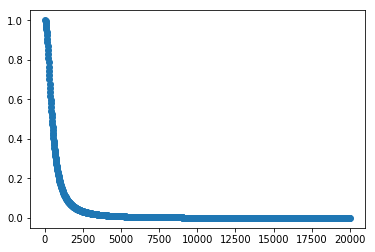

In [17]:
# Пример
w = real_w#get_mesh_lor(100)
plt.plot(w,Xn[200], 'o')

In [18]:
ind = [15, 800, 1400, 2005]
Y_for_test_graph = Y[ind]*10**9
X_for_test_graph = Xn[ind]
#X_for_test_graph = X[ind]

Y = np.delete(Y, ind, axis=0)
Xn = np.delete(Xn, ind, axis=0)
#X = np.delete(X, ind, axis=0)

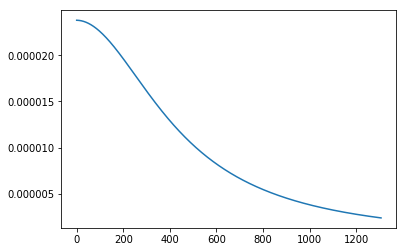

In [19]:
plt.plot(X[0])

In [20]:
# делим все на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(Xn, Y, test_size=0.33, shuffle=True,random_state=42)

In [21]:
# будем предсказывать нанометры 
y_train = y_train*10**9
y_test = y_test*10**9

In [22]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [23]:
#filepath = 'weights/best_weights_one_part.hdf5'
filepath = 'weights/best_weights_one_part_real_w.hdf5'

In [37]:
model = Sequential()
model.add(Dense(60, input_dim=X_train.shape[1]))
#model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(45))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(15))
model.add(Dense(1))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics = [rmse])
checkpoint = ModelCheckpoint(filepath, monitor='rmse', verbose=1, save_best_only=True, mode='min')

In [43]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_train[:1000], y_train[:1000]), 
                    epochs=100, 
                    batch_size=10, 
                    verbose=2)
                   #callbacks = [checkpoint])

Train on 3481 samples, validate on 1000 samples
Epoch 1/100
1s - loss: 579.0672 - rmse: 17.1358 - val_loss: 24.9703 - val_rmse: 3.7321
Epoch 2/100
1s - loss: 551.7138 - rmse: 16.5855 - val_loss: 20.9337 - val_rmse: 2.7765
Epoch 3/100
1s - loss: 544.1486 - rmse: 16.3589 - val_loss: 16.8240 - val_rmse: 3.0960
Epoch 4/100
1s - loss: 506.5688 - rmse: 15.8174 - val_loss: 42.9040 - val_rmse: 4.3437
Epoch 5/100
1s - loss: 511.6013 - rmse: 15.6101 - val_loss: 13.2384 - val_rmse: 2.1837
Epoch 6/100
1s - loss: 487.7268 - rmse: 15.3753 - val_loss: 11.1461 - val_rmse: 2.7610
Epoch 7/100
1s - loss: 448.9310 - rmse: 14.9898 - val_loss: 13.3324 - val_rmse: 2.8146
Epoch 8/100
1s - loss: 436.6135 - rmse: 14.8150 - val_loss: 91.7023 - val_rmse: 8.0884
Epoch 9/100
1s - loss: 433.2702 - rmse: 14.4592 - val_loss: 3.5705 - val_rmse: 1.3028
Epoch 10/100
1s - loss: 432.9941 - rmse: 14.7390 - val_loss: 22.5317 - val_rmse: 4.4100
Epoch 11/100
1s - loss: 399.7668 - rmse: 14.0162 - val_loss: 61.5284 - val_rmse: 6

KeyboardInterrupt: 

In [165]:
#model.load_weights("best_weights.hdf5")

значение метрик в нанометрах

In [61]:
# score on train
print(model.metrics_names)
model.test_on_batch(X_train, y_train)

['loss', 'rmse']


[3.5583141, 1.3157061]

In [62]:
# score on test
print(model.metrics_names)
model.test_on_batch(X_test, y_test)

['loss', 'rmse']


[3.8196485, 1.3766744]

In [59]:
X_test.shape

(1715, 1308)

In [63]:
linear_pred=[]
for i in tqdm_notebook(X_test):
    linear_pred.append(LRsolve_new(A, i, G))

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [64]:
np.sqrt(sklearn.metrics.mean_squared_error(y_test, linear_pred))

0.72260387469743093

## Visualization

In [28]:
# графики ошибки от количества итераций

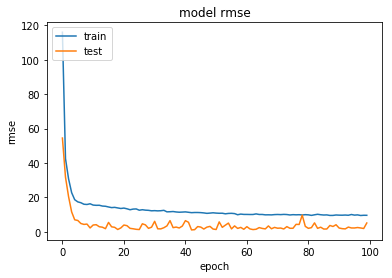

In [26]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
# рассмотрим частицы с такими диаметрам
print("Real diam:       ",Y_for_test_graph)
#X_for_test_graph
print("Predicted NN diam: ",model.predict(X_for_test_graph).T)
print("Predicted linear diam: ", [LRsolve_new(A, x, G) for x in X_for_test_graph])

Real diam:        [   2.00692441   54.70263512   94.97961146  135.59222927]
Predicted NN diam:  [[   8.75821686   57.16544342   95.80245972  136.28692627]]


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

Predicted linear diam:  [1.8639655275464093, 54.476746837004939, 97.81889864295438, 130.26393458414577]


In [51]:
d_max = 500*10**(-9)
d_min = 10**(-9)
G = getPowMesh(int(500), d_min,d_max ) #задем сетку
A = defineSystem(G, real_w)
LRsolve_new(A, X_for_test_graph[1], G)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


54.476746837004939

In [31]:
# синие точки - реальные значения, красные - предсказанные

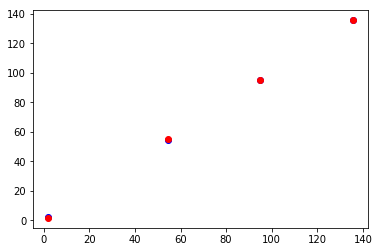

In [32]:
plt.plot(Y_for_test_graph, Y_for_test_graph, 'bo')
plt.plot(Y_for_test_graph, model.predict(X_for_test_graph), 'ro')

In [62]:
def LRsolve_new(A, y, G):
    M = A.shape[0]
    N = A.shape[1]
    
    # Non-negative ridge regression
    alpha = 1.3e-7
    B = np.zeros((M+N, N))
    B[0:M,:] = A
    B[M::, :] = alpha * np.eye(N)
    y_ = np.zeros(M+N)
    y_[0:M] = y
    a2, rnorm = scipy.optimize.nnls(B,y_)
    i, = np.where( a2==max(a2) )
    return 1e+9*coeff/G[i]
    

## best model

In [30]:
model = Sequential()
model.add(Dense(60, input_dim=X_train.shape[1]))
#model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(45))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(15))
model.add(Dense(1))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics = [rmse])
checkpoint = ModelCheckpoint(filepath, monitor='rmse', verbose=1, save_best_only=True, mode='min')

In [23]:
# score on train
print(model.metrics_names)
model.test_on_batch(X_train, y_train)

['loss', 'rmse']


[0.094575427, 0.27415904]

In [24]:
# score on test
print(model.metrics_names)
model.test_on_batch(X_test, y_test)

['loss', 'rmse']


[0.093630373, 0.27233303]

# TODO

* Сделать сетку по частоте неравномерную +
* попробовать поднять сигнал взять фурье и опустить 
(проблема в том, что при взятии обратного преобразования от лоренца не получается сигнал) + не помогло
* почитать про быстрое преобразование фурье, как правильно его делать +-

* многочастичный случай
* модельный сигнал 
* реальные данные
* хорошее разрешение малых размеров в одночастичном случае +